# Import des packages nécessaires

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score
from scipy.cluster.vq import kmeans,vq
import tqdm

# On définie le chemin du dossier d'entraînement et on affiche le nom des classes

In [5]:
train_path="dataset/intel_image/seg_train"
class_names=os.listdir(train_path)

print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# On ajoute les images dans un tableau et création d'un dictionnaire

In [6]:
image_paths=[]
image_classes=[]

# Function to List all the filenames in the directory

def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

for training_name in class_names:
    dir_=os.path.join(train_path,training_name)
    class_path=img_list(dir_)
    image_paths+=class_path
    
print(len(image_paths)) # ==> 14034

class_names_to_labels={'buildings':0,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
labels=[]

for image_path in image_paths:
    for class_name in class_names_to_labels.keys():
        if class_name in image_path:
            labels.append(class_names_to_labels[class_name])

image_classes=labels        
            

14034


# On ajoute toutes les images avec le label correspondant dans une liste

In [7]:
D=[]

for i in range(len(image_paths)):
    D.append((image_paths[i],image_classes[i]))

# Séparation aléatoire des images de test et des images d'entraînement

In [8]:
total = len(D)
random.shuffle(D)
train = D[:int(0.8 * total)]
test = D[int(0.2 * total):]

image_paths, y_train = zip(*train)
image_paths_test, y_test = zip(*test)

# Extraction des points clés en utilisant ORB

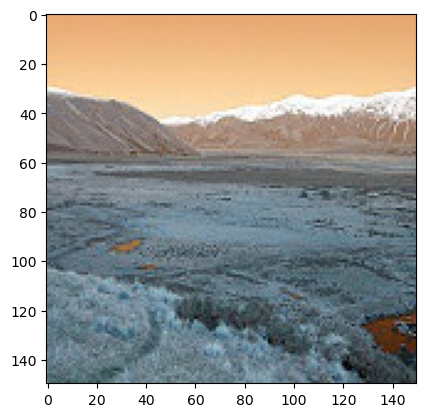

In [9]:
des_list=[]

orb=cv2.ORB_create()

im=cv2.imread(image_paths[1])

plt.imshow(im)

# Affichage des points clés

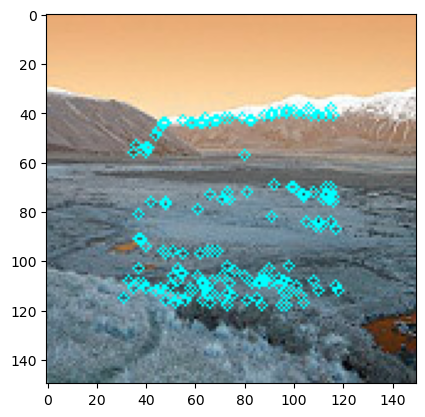

In [10]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color))
           
kp = orb.detect(im,None)
kp, des = orb.compute(im, kp)
img=draw_keypoints(im,kp)

# Ajout des descripteurs des images dans une liste

In [88]:
for image_pat in image_paths:
    if image_pat is None:
        continue
    im=cv2.imread(image_pat)
    # if im is None:
    #     print(f"Image {image_pat} could not be read")
    #     continue
    kp=orb.detect(im,None)
    # if kp is None:
    #     print(f"Keypoints could not be detected in {image_pat}")
    #     continue
    keypoints,descriptor= orb.compute(im, kp)
    if descriptor is None:
        print(f"Descriptor could not be computed in {image_pat}")
        continue
    
    print(f"Image path: {image_pat} - keypoints: {len(keypoints)} - descriptor shape: {descriptor.shape}")
    des_list.append((image_pat,descriptor))
    


Image path: dataset/seg_train\mountain\9083.jpg - keypoints: 267 - descriptor shape: (267, 32)
Image path: dataset/seg_train\sea\18891.jpg - keypoints: 260 - descriptor shape: (260, 32)
Image path: dataset/seg_train\mountain\9894.jpg - keypoints: 77 - descriptor shape: (77, 32)
Image path: dataset/seg_train\buildings\18755.jpg - keypoints: 308 - descriptor shape: (308, 32)
Image path: dataset/seg_train\glacier\18231.jpg - keypoints: 282 - descriptor shape: (282, 32)
Image path: dataset/seg_train\sea\17837.jpg - keypoints: 107 - descriptor shape: (107, 32)
Image path: dataset/seg_train\buildings\8553.jpg - keypoints: 317 - descriptor shape: (317, 32)
Image path: dataset/seg_train\glacier\7673.jpg - keypoints: 188 - descriptor shape: (188, 32)
Image path: dataset/seg_train\buildings\8366.jpg - keypoints: 246 - descriptor shape: (246, 32)
Image path: dataset/seg_train\buildings\18743.jpg - keypoints: 275 - descriptor shape: (275, 32)
Image path: dataset/seg_train\glacier\18430.jpg - keypo

In [90]:
print(len(des_list[0][1]))
descriptors= des_list[0][1]
print(descriptors.shape)
print(des_list[0][1].shape)

267
(267, 32)
(267, 32)


In [91]:
image_in_error = 0
for image_path,descriptor in des_list[1:]:
    descriptors=np.vstack((descriptors,descriptor))
    
print(descriptors.shape)
print(f"Number of images in error: {image_in_error}")

descriptors_float=descriptors.astype(float)

(2802720, 32)
Number of images in error: 0


# Clustering des descriptors en utilisant KMeans

In [92]:
k=200
voc,variance=kmeans(descriptors_float,k,1)

In [110]:
print(len(image_paths))
print(len(des_list))

im_features=np.zeros((len(image_paths),k),"float32")
for i in range(len(image_paths)-1):
    words,distance=vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w]+=1

11227
11226


# Standardisation sur les éléments d'entraînement

In [96]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

In [97]:
print(im_features.shape)
print(len(y_train))

(11227, 200)
11227


# Création et test du modèle de classification

In [ ]:
from sklearn.svm import SVC
clf=SVC()
clf.fit(im_features,np.array(y_train))

In [112]:
des_list_test=[]
            
for image_pat in image_paths_test:
    image=cv2.imread(image_pat)
    kp=orb.detect(image,None)
    keypoints_test,descriptor_test= orb.compute(image, kp)
    if descriptor_test is None:
        print(f"Descriptor could not be computed in {image_pat}")
        continue
    print(f"Image path: {image_pat} - keypoints: {len(keypoints_test)} - descriptor shape: {descriptor_test.shape}")
    des_list_test.append((image_pat,descriptor_test))
            
len(image_paths_test)

Image path: dataset/seg_train\sea\12198.jpg - keypoints: 50 - descriptor shape: (50, 32)
Image path: dataset/seg_train\mountain\14564.jpg - keypoints: 284 - descriptor shape: (284, 32)
Image path: dataset/seg_train\glacier\15782.jpg - keypoints: 155 - descriptor shape: (155, 32)
Image path: dataset/seg_train\sea\19732.jpg - keypoints: 83 - descriptor shape: (83, 32)
Image path: dataset/seg_train\mountain\15473.jpg - keypoints: 158 - descriptor shape: (158, 32)
Image path: dataset/seg_train\glacier\17958.jpg - keypoints: 265 - descriptor shape: (265, 32)
Image path: dataset/seg_train\glacier\18941.jpg - keypoints: 271 - descriptor shape: (271, 32)
Image path: dataset/seg_train\forest\438.jpg - keypoints: 277 - descriptor shape: (277, 32)
Image path: dataset/seg_train\mountain\16972.jpg - keypoints: 183 - descriptor shape: (183, 32)
Image path: dataset/seg_train\buildings\18602.jpg - keypoints: 311 - descriptor shape: (311, 32)
Image path: dataset/seg_train\forest\5014.jpg - keypoints: 2

11228

In [117]:
test_features=np.zeros((len(image_paths_test),k),"float32")
for i in range(len(des_list_test)):
    words,distance=vq(des_list_test[i][1],voc)
    for w in words:
        test_features[i][w]+=1

11228
11216
50


# Vérification et précision des résultats

In [121]:
test_features=stdslr.transform(test_features)

true_classes=[]
print(len(y_test))
for i in range(len(y_test)):
    true_classes.append(y_test[i])


predict_classes=[]
print(len(test_features))
for i in range(len(test_features)):
    predict_classes.append(clf.predict(test_features[i].reshape(1,-1)))

clf.predict(test_features)


accuracy=accuracy_score(true_classes,predict_classes)
print(accuracy)
            
            
# Matrice de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, predict_classes)

11228
11228
0.17812611328820804


Il y a 7301 images dans le dossier de test
La classe prédit est : mountain


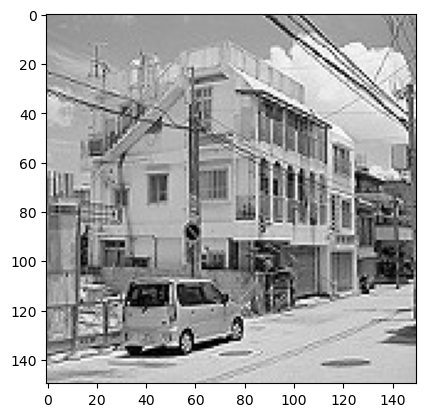

In [148]:
# test avec une image de test prise au hasard dans le dossier seg_pred
import random
import pathlib
seg_pred_dir = pathlib.Path("dataset/seg_pred")
seg_pred_image_count = len(list(seg_pred_dir.glob('*.jpg')))
print("Il y a {} images dans le dossier de test".format(seg_pred_image_count))
random_number = random.randint(0, seg_pred_image_count)
seg_pred_image = list(seg_pred_dir.glob('*.jpg'))[random_number]
seg_pred_image = cv2.imread(str(seg_pred_image))
plt.figure()
plt.imshow(seg_pred_image)

# on récupère les keypoints de l'image
kp=orb.detect(seg_pred_image,None)
keypoints_test,descriptor_test= orb.compute(seg_pred_image, kp)

# on récupère les descripteurs de l'image
words,distance=vq(descriptor_test,voc)

# on récupère les features de l'image
test_features=np.zeros((1,k),"float32")
for w in words:
    test_features[0][w]+=1

# on standardise les features de l'image
test_features=stdslr.transform(test_features)

# on prédit la classe de l'image
predict_class=clf.predict(test_features)
#print la classe prédite de l'image avec le nom de la classe en mot et non en chiffre
if predict_class == 0:
    predict_class = "buildings"
elif predict_class == 1:
    predict_class = "forest"
elif predict_class == 2:
    predict_class = "glacier"
elif predict_class == 3:
    predict_class = "mountain"
elif predict_class == 4:
    predict_class = "sea"
elif predict_class == 5:
    predict_class = "street"
    
print("La classe prédit est :", predict_class)
